In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches, colormaps
from tqdm.notebook import tqdm
import pickle

import utils_string as uts
import utils as ut
import utils_phase_diagr as ut_pd

### Testing the generation of strings with desired recruited number and affinities

In [2]:
R = 500
string_model = uts.TT_string(N_tot=10**6, L_string=30, N_recruit=100)

logts_mean, logts_std, N_recrs = [], [], []
progress = tqdm(total=R)
for _ in range(R):
    recruit_strings, h_recruit = string_model.gen_and_recruit_string()
    logtaus = string_model.get_logtau(h_recruit)
    logts_mean.append(np.mean(logtaus))
    logts_std.append(np.std(logtaus))
    N_recrs.append(len(h_recruit))
    progress.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

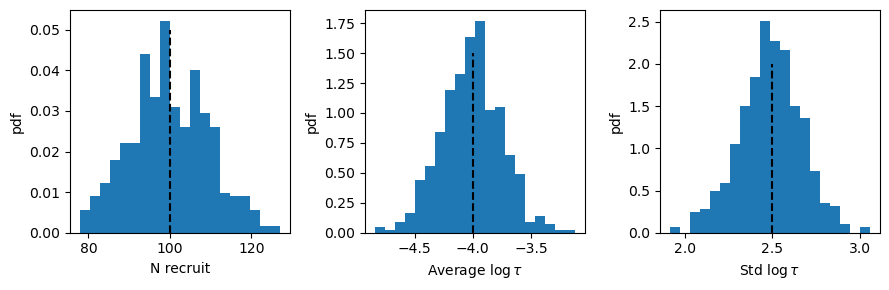

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))

ax1.set_xlabel('N recruit')
ax1.set_ylabel('pdf')
ax1.hist(N_recrs, bins=20, density=True)
Nr = string_model.N_recr
ax1.plot([Nr, Nr], [0, 1/np.sqrt(Nr)/2], c='k', ls='--')

ax2.set_xlabel(r'Average $\log \tau$')
ax2.set_ylabel('pdf')
ax2.hist(logts_mean, bins=20, density=True)
ax2.plot([-4, -4], [0, 1.5], c='k', ls='--')

ax3.set_xlabel(r'Std $\log \tau$')
ax3.set_ylabel('pdf')
ax3.hist(logts_std, bins=20, density=True)
ax3.plot([2.5, 2.5], [0, 2], c='k', ls='--')

plt.tight_layout()

### Genereting an ensemble of recruited binary clones at given string-model parameters

In [5]:
string_model = uts.TT_string(N_tot=10**7, L_string=30, N_recruit=100)

R_string = 1000
string_ens = []
progress = tqdm(total=R_string)
for _ in range(R_string):
    recruit_strings, h_recruit = string_model.gen_and_recruit_string()
    string_ens.append(recruit_strings)
    progress.update(1)

with open(f'out_data/string_model/string_ensamble.pkl', 'wb') as f:
    pickle.dump(string_ens, f)

sr = pd.Series(string_model.get_pars())
sr.to_csv('out_data/string_model/string_params.tsv', sep='\t', header=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Computing beta0 at constant time of max expansion 

In [345]:
def get_av_t_Tmax(alpha0, beta0, logtau_ens, R):

    ts = []
    for _ in range(R):

        logtaus = logtau_ens[np.random.randint(0, len(logtau_ens))]
        pars = ut.TT_params(np.exp(logtaus), alpha0=alpha0, beta0=beta0)
        times, T_trajs, _, _ = ut.run_setting(pars, ut.tau_sampler_lognorm(), 5000, 'adapt', traj_steps=50)

        # Tricky computation of max expansion because of trajectories that get extinct (for low alpha0)
        # We remove from computation trajectories that were never above 1
        extinct_traj = np.all(T_trajs <= 1, axis=0)
        T_tot = np.sum(T_trajs[:,~extinct_traj], axis=1)
        ts.append(times[np.argmax(T_tot)])

    return np.mean(ts)


with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens = pickle.load(f)

pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', header=None, index_col=0)[1].to_dict()
string_model = uts.TT_string(N_tot=pars['N_tot'], L_string=int(pars['L_string']), N_recruit=pars['N_recruit'])

name = '1'
mean_logtau, std_logtau = -2, 2
R_beta0 = 50
t_T_max = 9
t_T_max_tol = 0.05
alpha0s = np.logspace(-5.5, -3, 50)

logtau_ens = []
for i, strings in enumerate(string_ens):
    h_dists = uts.comp_h_dist(strings, np.zeros(len(strings[0])))
    logtau_ens.append(string_model.get_logtau(h_dists, mean_logtau, std_logtau))

#### Checing trajectories

In [268]:
# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm(logmean=mean_logtau, logstd=std_logtau)

# Defining the default realistic paramters
taus = np.exp(logtau_ens[3])
pars = ut.TT_params(taus, alpha0=1e-2, beta0=0.22)

# Integration parameters
traj_steps, dt = 50, 0.005
t_steps = int(30 / dt)

times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, tau_samp, t_steps, dt, traj_steps=traj_steps)

extinct_traj = np.all(T_trajs <= 1, axis=0)
T_tot = np.sum(T_trajs[:,~extinct_traj], axis=1)
t_max = times[np.argmax(T_tot)]
#if t_max == 0:
    # Tricky case of low abundance trajectories, where they get 
    # extincted. The maximum is relative to the lowest growing clone
#    min_t = np.argmin(T_trajs[-1])
#    t_max = times[np.argmax(np.array(T_tot)-100*T_trajs[:,min_t])]
print(t_max)

8.75


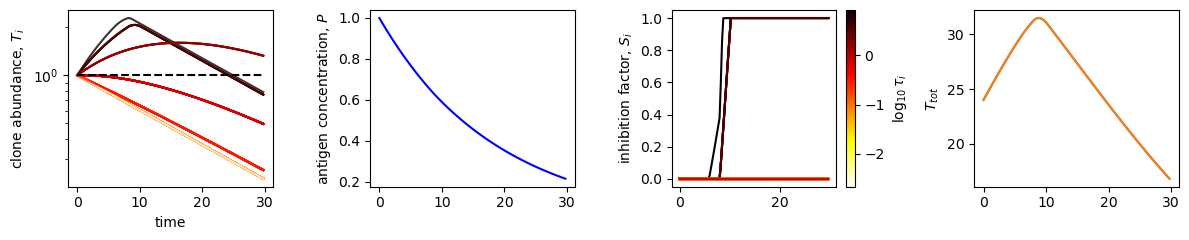

In [269]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(12,2.5))

ax1.set_yscale('log')
ax1.set_xlabel('time')
ax1.set_ylabel(r'clone abundance, $T_i$')
cmap = colormaps.get_cmap('hot_r')
cmap_norm = plt.Normalize(vmin=min(np.log10(taus)), vmax=max(np.log10(taus)))
for i, Ts in enumerate(T_trajs.T):
    color = cmap(cmap_norm(np.log10(taus[i])))
    ax1.plot(times, Ts, c=color, alpha=0.8)
    
#ax1.set_ylim(0.9, np.max(T_trajs)*1.1)

#ax1.plot(times, T_tot, c='b', label=r'$\sum_i T_i$')
ax1.plot(times, np.ones(len(times)), c='k', ls='--')
#ax1.legend()

ax2.set_ylabel(r'antigen concentration, $P$')
ax2.plot(times, P_trajs, c='b')

ax3.set_ylabel(r'inhibition factor, $S_i$')
for i, Ss in enumerate(S_trajs.T):
    color = cmap(cmap_norm(np.log10(taus[i])))
    ax3.plot(times, Ss, c=color)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=cmap_norm)
sm.set_array([])
fig.colorbar(sm, ax=ax3, label=r'$\log_{10} \tau_i$')

plt.plot(times, np.array(T_tot))

ax4.set_ylabel(r'$T_{tot}$')
min_t = np.argmin(T_trajs[-1])
ax4.plot(times, np.array(T_tot), label=r'$\sum T_i$')
#ax4.plot(times, np.array(T_tot)-100*T_trajs[:,min_t], label=r'$\sum T_i - N_{recr} * T_{min}$')
#ax4.legend()
plt.tight_layout()

#### Computing 

In [346]:
beta0s = []
progress = tqdm(total=len(alpha0s))
for a0 in alpha0s:
    func = lambda x : get_av_t_Tmax(a0, x, logtau_ens, R_beta0) - t_T_max
    beta0s.append(ut.bisection(func, 0.4, 2, t_T_max_tol))
    progress.update(1)

with open(f'out_data/string_model/{name}_a0s_b0s.pkl', 'wb') as f:
    pickle.dump((alpha0s, beta0s), f)

# Export params as well
pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', index_col=0, header=None)
sr = pd.Series({'mean_logtau':mean_logtau, 'std_logtau':std_logtau, 'R_beta0':R_beta0, 't_T_max':t_T_max, 't_T_max_tol':t_T_max_tol}, name=1)
pd.concat((pars, sr)).to_csv(f'out_data/string_model/{name}_string_params.tsv', sep='\t', header=None)


  0%|          | 0/50 [00:00<?, ?it/s]

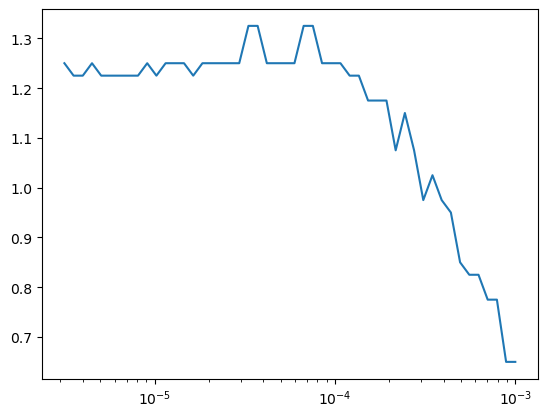

In [347]:
plt.xscale('log')
plt.plot(alpha0s, beta0s)

### Generating abundance trajectories for each alpha0-beta0

In [349]:
name = '1'

with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens = pickle.load(f)

with open(f'out_data/string_model/{name}_a0s_b0s.pkl', 'rb') as f:
    alpha0s, beta0s = pickle.load(f)

pars = pd.read_csv(f'out_data/string_model/{name}_string_params.tsv', sep='\t', header=None, index_col=0)[1].to_dict()
string_model = uts.TT_string(N_tot=pars['N_tot'], L_string=int(pars['L_string']), N_recruit=pars['N_recruit'])

R_traj = 250
mem_time = 30
dt = 0.005
n_time_steps = int(mem_time / dt)

In [350]:
string_ids_ens, Ts_final_ens,  = [], []
x_maxs_ens, n_xmax_ens = [], []

progress = tqdm(total=len(alpha0s))
for i in range(len(alpha0s)):

    string_aux, Ts_aux, taus_mat = [], [], []
    for _ in range(R_traj):
        
        # Sampling on id of the generated recruited strings
        i_string_ens = np.random.randint(0, len(logtau_ens))
        string_aux.append(i_string_ens)

        # Generating a trajectory until memory
        taus_mat.append(np.exp(logtau_ens[i_string_ens]))
        pars = ut.TT_params(taus_mat[-1], alpha0=alpha0s[i], beta0=beta0s[i])
        _, Ts_mat, _, _ = ut.run_setting(pars, ut.tau_sampler_lognorm(), n_time_steps, dt, traj_steps=50)
        Ts_aux.append(Ts_mat[-1])

    # Computing some observables
    if alpha0s[i] > 5e-4: qt = 0.995 # Setting the sensitivty to outliers depending on alpha0)
    else: qt = 0.999
    x_max, y_max, n_x_max, outcome = ut_pd.find_max(taus_mat, Ts_aux, smooth_bins=50, quantile_taus=qt)
    x_maxs_ens.append(x_max)
    n_xmax_ens.append(n_x_max)

    string_ids_ens.append(string_aux)
    Ts_final_ens.append(Ts_aux)
    progress.update(1)

with open(f'out_data/string_model/{name}_Ts_final.pkl', 'wb') as f:
    pickle.dump((string_ids_ens, Ts_final_ens, x_maxs_ens, n_xmax_ens), f)

# Export params as well
pars = pd.read_csv(f'out_data/string_model/{name}_string_params.tsv', sep='\t', index_col=0, header=None)
sr = pd.Series({'R_traj':R_traj, 'mem_time':mem_time, 'dt':dt}, name=1)
pd.concat((pars, sr)).to_csv(f'out_data/string_model/{name}_string_params.tsv', sep='\t', header=None)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/andrea/Research/Immuno/TT-inhibition/utils_phase_diagr.py:80: RuntimeWarning: invalid value encountered in divide
  ders = [(logT[i][1:] - logT[i][:-1]) / (logtaus[i][1:] - logtaus[i][:-1]) for i in range(len(logtaus))]


### Analysis of the generated clonotype abundances and coverage

In [340]:
def comp_coverage_h_norm(strings, abunds, target_string):
    L = len(target_string)
    h_dists = uts.comp_h_dist(strings, target_string)
    return np.sum(abunds*(L - h_dists)) / np.sum(abunds)

def comp_coverage_h(strings, abunds, target_string):
    L = len(target_string)
    h_dists = uts.comp_h_dist(strings, target_string)
    return np.sum(abunds*(L - h_dists))

def comp_coverage_tau_norm(strings, abunds, target_string):
    h_dists = uts.comp_h_dist(strings, target_string)
    logtaus = string_model.get_logtau(h_dists)
    return np.sum(abunds*np.exp(logtaus)) / np.sum(abunds)

def compute_inv_simps(Ts_mat):
    """
    Compute the inverse Simpson's index for a list of audaces arrays.
    It discards abundances smaller than 1.
    """
    T_freqs_mat = [T / np.sum(T) for T in Ts_mat]
    inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])
    inv_simps = inv_simps[~np.isnan(inv_simps)]
    inv_simps = inv_simps[~np.isinf(inv_simps)]
    return np.mean(inv_simps)

In [351]:
name = '1'

with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens = pickle.load(f)

with open(f'out_data/string_model/{name}_a0s_b0s.pkl', 'rb') as f:
    alpha0s, beta0s = pickle.load(f)

with open(f'out_data/string_model/{name}_Ts_final.pkl', 'rb') as f:
    string_ids_ens, Ts_final_ens, x_maxs_ens, n_xmax_ens = pickle.load(f)

pars = pd.read_csv(f'out_data/string_model/{name}_string_params.tsv', sep='\t', header=None, index_col=0)[1].to_dict()

In [352]:
Rt = int(pars['R_traj'])
L = int(pars['L_string'])
muts = [[], np.arange(2), np.arange(int(L/4)), np.arange(int(L/2)), np.arange(int(3*L/4)), np.arange(L)]
cover_h, covers_h_norm, covers_tau_norm = [], [], []
T_tots, inv_simpss = [], []

for i in range(len(alpha0s)):
    strings = [string_ens[k] for k in string_ids_ens[i]]
    logtaus = [logtau_ens[k] for k in string_ids_ens[i]]

    cover_h_aux, covers_h_norm_aux, covers_tau_norm_aux = [], [], []
    for mut in muts:
        a_mut = np.zeros(int(pars['L_string']))
        a_mut[mut] = 1
        cs = [comp_coverage_h(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        cover_h_aux.append(np.mean(cs))
        cs = [comp_coverage_h_norm(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        covers_h_norm_aux.append(np.mean(cs))
        cs = [comp_coverage_tau_norm(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        covers_tau_norm_aux.append(np.mean(cs))

    cover_h.append(cover_h_aux)
    covers_h_norm.append(covers_h_norm_aux)
    covers_tau_norm.append(covers_tau_norm_aux)

    T_tots.append(np.mean( [np.sum(Ts_final_ens[i][r]) for r in range(Rt)] ))
    inv_simpss.append(compute_inv_simps(Ts_final_ens[i]))

cover_h, covers_h_norm, covers_tau_norm = np.array(cover_h), np.array(covers_h_norm), np.array(covers_tau_norm)

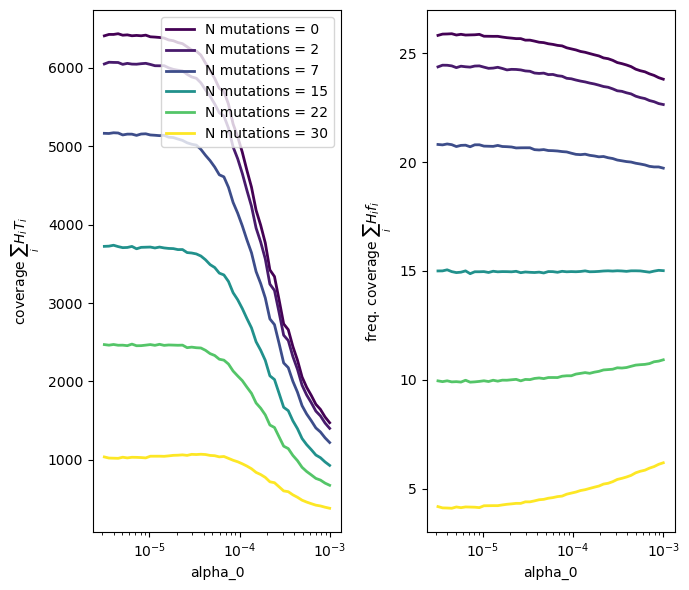

In [353]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7, 6))
cmap = colormaps.get('viridis')

for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_xlabel('alpha_0')

ax1.set_ylabel(r'coverage $\sum_i H_i T_i$')
ax2.set_ylabel(r'freq. coverage $\sum_i H_i f_i$')
for i, mut in enumerate(muts):
    c = cmap(len(mut)/L)
    ax1.plot(alpha0s, cover_h[:,i], label=f'N mutations = {len(mut)}', c=c, lw=2)
    ax2.plot(alpha0s, covers_h_norm[:,i], label=f'N mutations = {len(mut)}', c=c, lw=2)
ax1.legend()

plt.tight_layout()
plt.savefig(f'plots/evo_model_coverage/{name}_coverage.svg', facecolor='w')


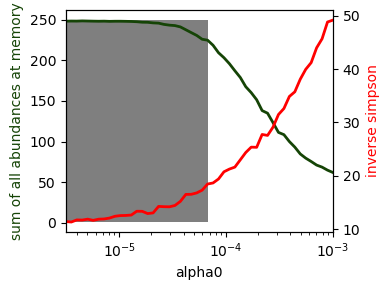

In [354]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.set_xscale('log')
ax1.set_xlabel('alpha0')
ax1.set_xlim(alpha0s[0], alpha0s[-1])

c1, c2 = '#154406', 'r'
ax2 = ax1.twinx()

# Create a Rectangle patch
first_max_i = list((np.array(n_xmax_ens) / Rt) < 0.85).index(False)
w = alpha0s[first_max_i-1] - alpha0s[0]
rect = patches.Rectangle((alpha0s[0], 1), w, max(T_tots), linewidth=1, facecolor='k', alpha=0.5)
ax1.add_patch(rect)

ax1.set_ylabel('sum of all abundances at memory', color=c1)
ax1.plot(alpha0s, np.array(T_tots), c=c1, lw=2)
#ax1.set_ylim(1, max(factors)+0.2)

ax2.set_ylabel('inverse simpson', color=c2)
ax2.plot(alpha0s, inv_simpss, c=c2, lw=2)

plt.tight_layout()
plt.savefig(f'plots/evo_model_coverage/{name}_tradeoff.svg', facecolor='w')

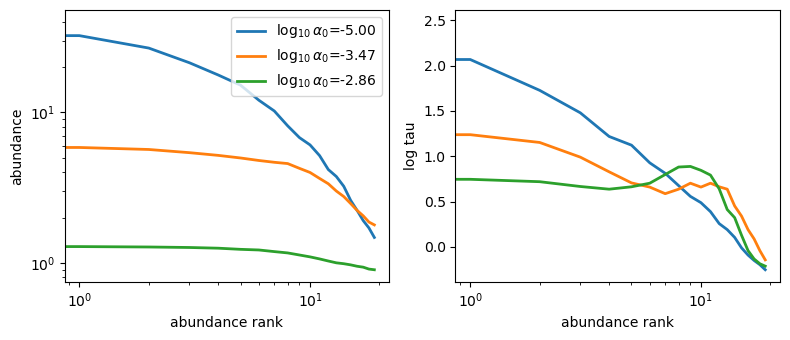

In [ ]:
i_alphas = [0, 25, 35]
max_rank = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))

ax1.set_xlabel('abundance rank')
ax1.set_ylabel('abundance')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.set_xlabel('abundance rank')
ax2.set_ylabel('log tau')
ax2.set_xscale('log')

for i, i_alpha in enumerate(i_alphas):

    av_T_rank, av_lt_rank, T_rank_count = np.zeros(max_rank), np.zeros(max_rank),  np.zeros(max_rank)
    for r, Ts in enumerate(Ts_final_ens[i_alpha]):
        rank = np.argsort(Ts)[::-1][:min(len(Ts), max_rank)]
        av_T_rank += np.array(Ts[rank])
        av_lt_rank += np.array(logtau_ens[string_ids_ens[i_alpha][r]])[rank]
        T_rank_count += 1
    av_T_rank /= T_rank_count
    av_lt_rank /= T_rank_count

    lab = r'$\log_{10}\alpha_0$=%3.2f'%np.log10(alpha0s[i_alpha])
    ax1.plot(np.arange(max_rank), av_T_rank, label=lab, lw=2)
    ax2.plot(np.arange(max_rank), av_lt_rank, label=lab, lw=2)

ax1.legend()

plt.tight_layout()
plt.savefig(f'plots/evo_model_coverage/{name}_abundance-affinity.svg', facecolor='w')

-2.857142857142857


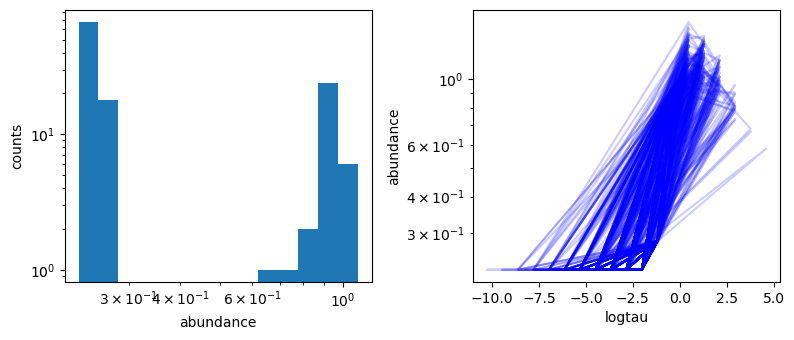

In [328]:
i = 35
r = 6
print(np.log10(alpha0s[i]))

fig,  (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5))

ax1.set_xlabel('abundance')
ax1.set_ylabel('counts')
ax1.set_xscale('log')
ax1.set_yscale('log')
bins = np.logspace(min(np.log10(Ts_final_ens[i][r])), max(np.log10(Ts_final_ens[i][r])), 15)
h = ax1.hist(Ts_final_ens[i][r], bins=bins)

ax2.set_ylabel('abundance')
ax2.set_xlabel('logtau')
ax2.set_yscale('log')

for r in range(30):
    ax2.plot(logtau_ens[string_ids_ens[i][r]], Ts_final_ens[i][r], alpha=0.2, c='b')

plt.tight_layout()

We have the best string $(0,0,\ldots,0)$ with freq $f_0$ and $n$ string with one mutation at abundance $f_1$.
Then the coverage against $a_0$ is:
$$
C(a_0) = L f_0 + (L-1) n f_1
$$

The coverage against a mutated antigen (1 mutation) is instead:
$$
C(a_1) = (L-1) f_0 + f_1 \sum_{k=1}^n P(\text{k clones have the right mutation}) (k L + (n-k) (L - 2))
$$
$$
= (L-1) f_0 + f_1 \sum_{k=1}^n {\rm Binom}\left(k \left| n, \frac{1}{L}\right. \right) (n (L - 2) + 2 k)
$$
$$
= (L-1) f_0 + f_1 \left( n (L - 2) + 2 \sum_{k=1}^n k {\rm Binom}\left(k \left| n, \frac{1}{L}\right. \right) \right) = (L-1) f_0 + f_1 n \left( L - 2 + \frac{2}{L} \right)

$$

$$
\Delta C = C(a_0) - C(a_1) = L f_0 + (L-1) n f_1 - (L-1) f_0 - f_1 n \left( L - 2 + \frac{2}{L} \right)
$$
$$
\Delta C = C(a_0) - C(a_1) = f_0 + f_1 n \left( 1 - \frac{2}{L} \right)
$$